# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment4"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/path_to/assignment4" $datadir # TODO: Fill your Assignment 4 path
os.chdir(datadir)
!pwd

# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss
from gan.utils import show_images

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MNIST Dataset


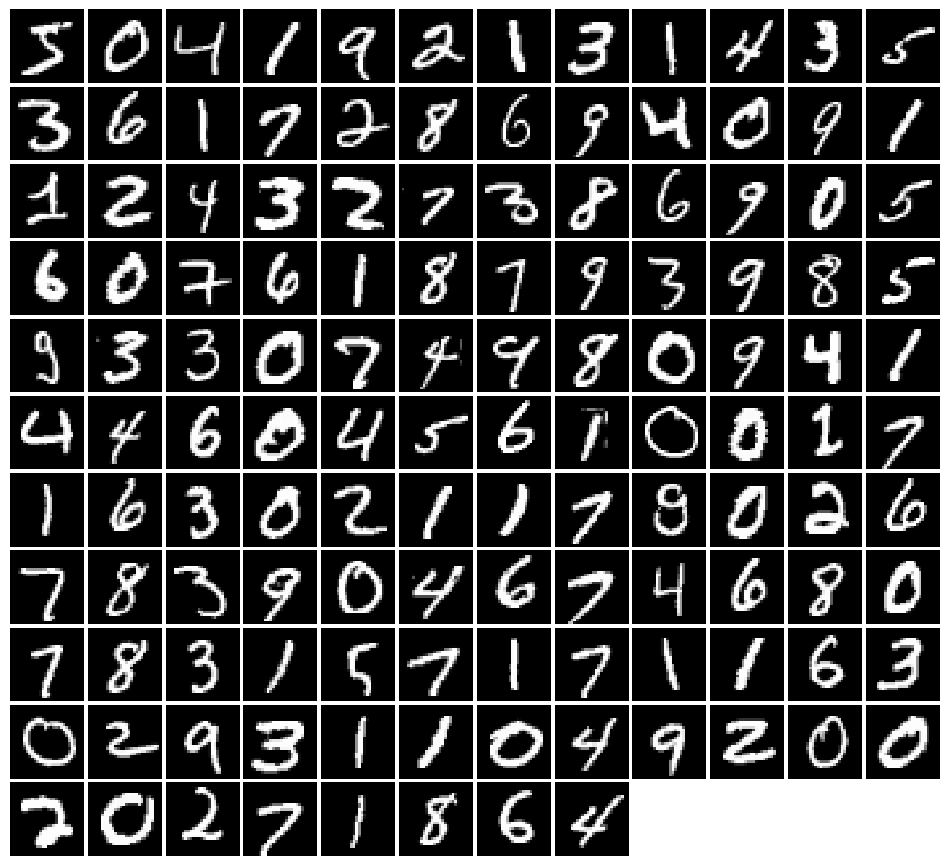

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)

try:
  imgs = next(iter(loader_train))[0].view(batch_size, 784).numpy().squeeze()
except:
  imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()

show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.383, G:0.6915


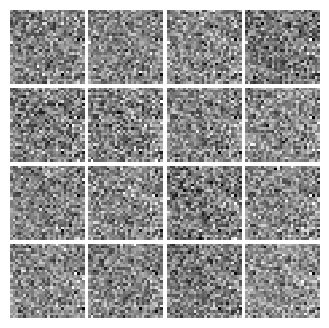


Iter: 250, D: 1.375, G:0.7307


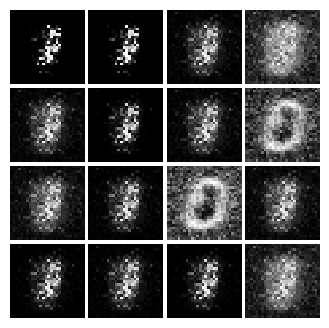


EPOCH:  2
Iter: 500, D: 1.316, G:1.194


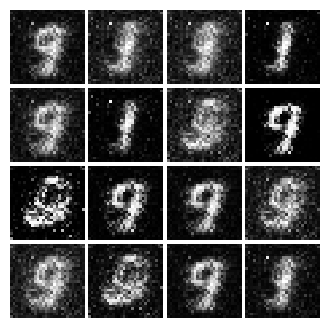


Iter: 750, D: 0.9897, G:1.45


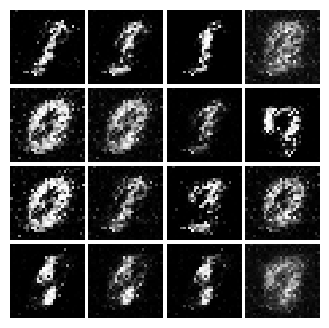


EPOCH:  3
Iter: 1000, D: 1.163, G:1.036


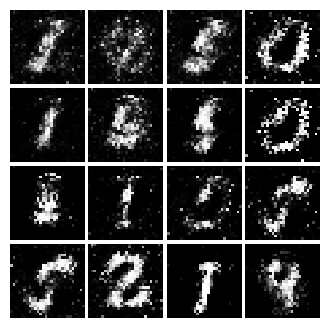


Iter: 1250, D: 1.167, G:1.087


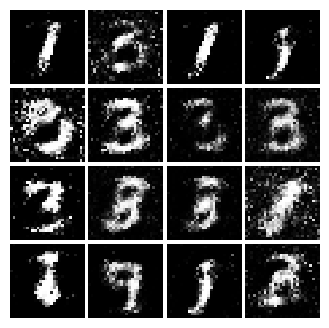


EPOCH:  4
Iter: 1500, D: 1.136, G:0.9895


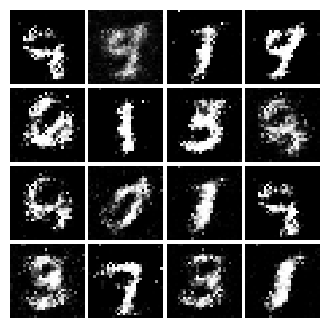


Iter: 1750, D: 1.282, G:0.8646


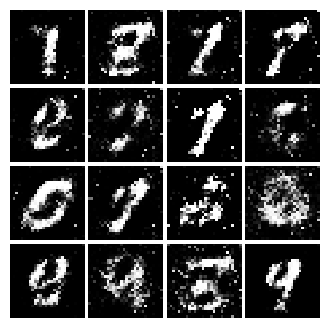


EPOCH:  5
Iter: 2000, D: 1.281, G:0.9136


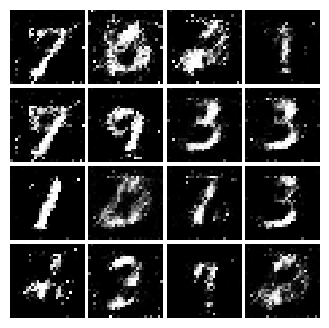


Iter: 2250, D: 1.181, G:1.005


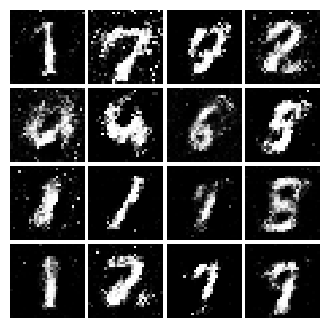


EPOCH:  6
Iter: 2500, D: 1.329, G:0.8471


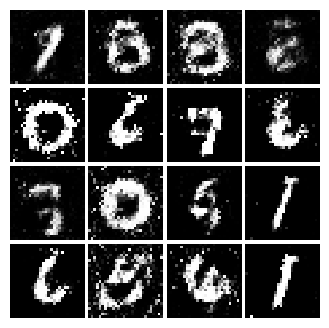


Iter: 2750, D: 1.223, G:0.9022


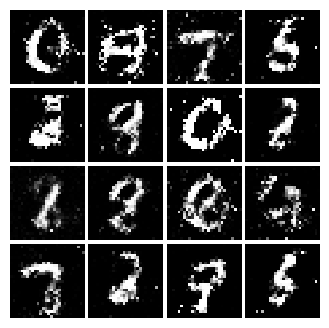


EPOCH:  7
Iter: 3000, D: 1.322, G:0.8384


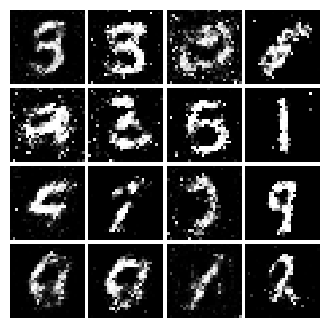


Iter: 3250, D: 1.144, G:0.9737


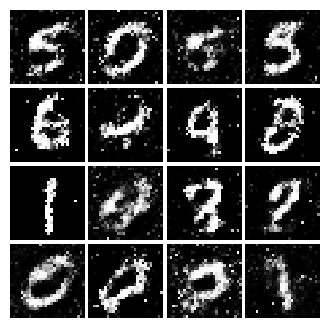


EPOCH:  8
Iter: 3500, D: 1.259, G:0.8531


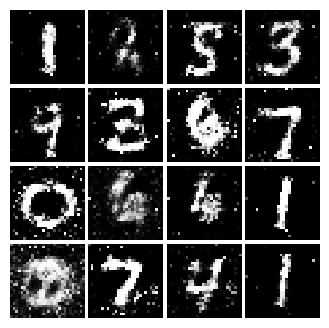


EPOCH:  9
Iter: 3750, D: 1.246, G:0.8618


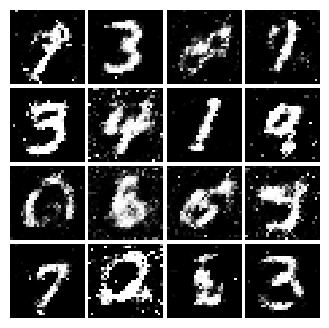


Iter: 4000, D: 1.37, G:0.8249


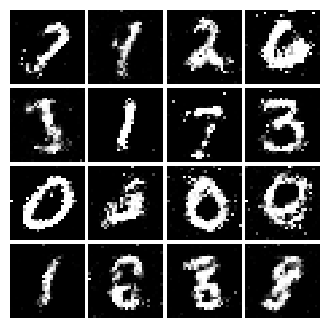


EPOCH:  10
Iter: 4250, D: 1.351, G:0.8013


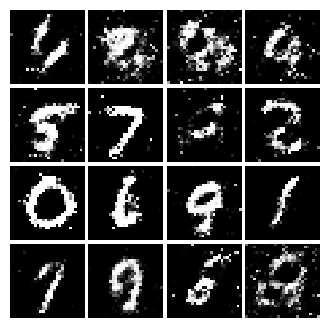


Iter: 4500, D: 1.279, G:0.9071


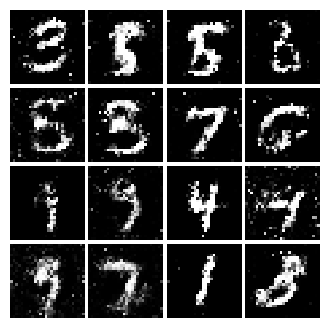

In [9]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device,show_every=250,batch_size=batch_size,noise_size=NOISE_DIM)

EPOCH:  1
Iter: 0, D: 0.5044, G:0.5472


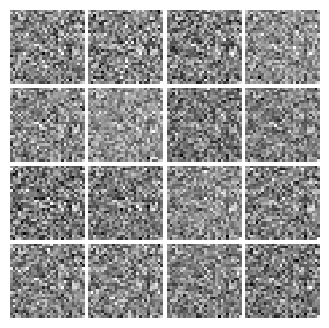


Iter: 250, D: 0.1836, G:0.2187


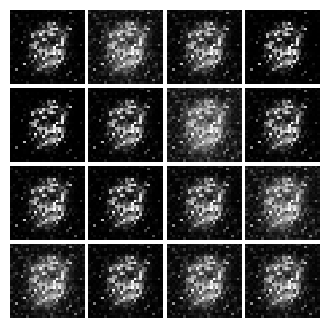


EPOCH:  2
Iter: 500, D: 0.062, G:0.3988


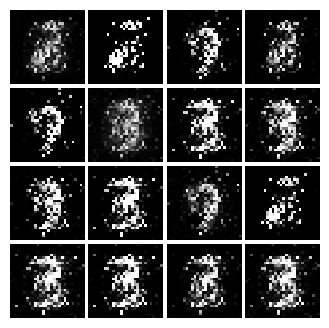


Iter: 750, D: 0.2564, G:0.0444


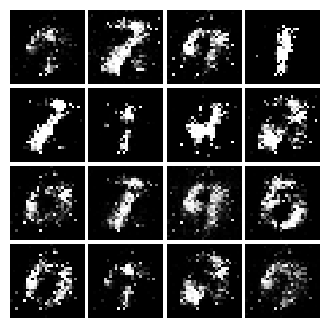


EPOCH:  3
Iter: 1000, D: 0.1472, G:0.3164


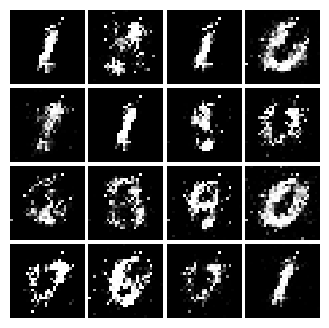


Iter: 1250, D: 0.1277, G:0.3119


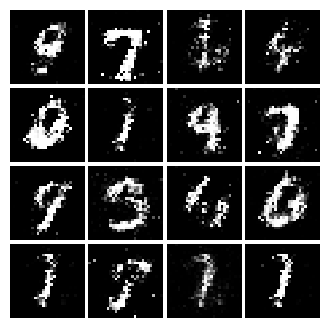


EPOCH:  4
Iter: 1500, D: 0.1933, G:0.1567


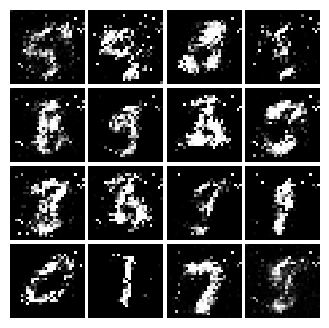


Iter: 1750, D: 0.2029, G:0.2199


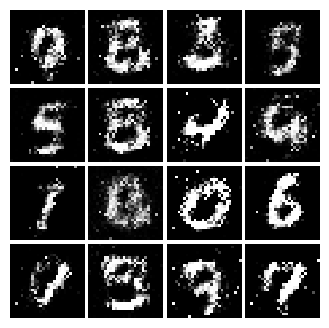


EPOCH:  5
Iter: 2000, D: 0.1944, G:0.1998


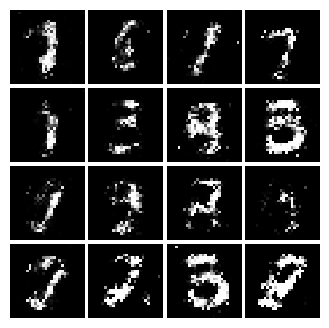


Iter: 2250, D: 0.1961, G:0.2061


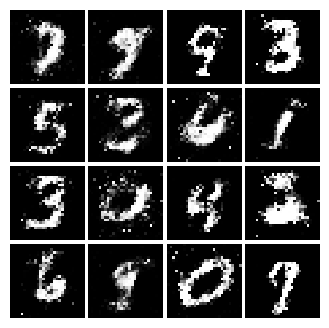


EPOCH:  6
Iter: 2500, D: 0.1902, G:0.1763


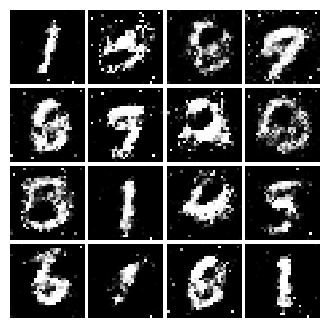


Iter: 2750, D: 0.2275, G:0.1773


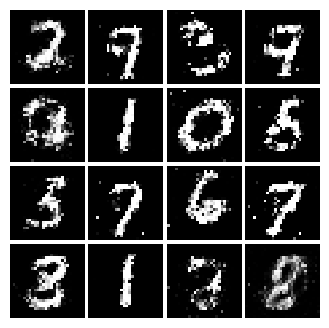


EPOCH:  7
Iter: 3000, D: 0.2059, G:0.209


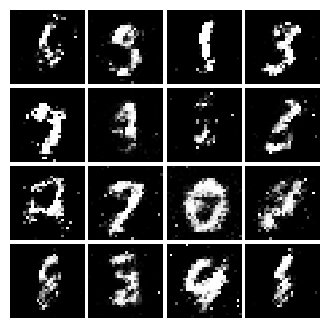


Iter: 3250, D: 0.2039, G:0.1858


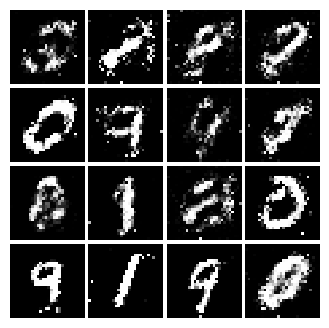


EPOCH:  8
Iter: 3500, D: 0.2439, G:0.1837


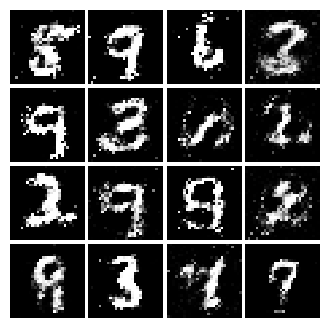


EPOCH:  9
Iter: 3750, D: 0.2244, G:0.1656


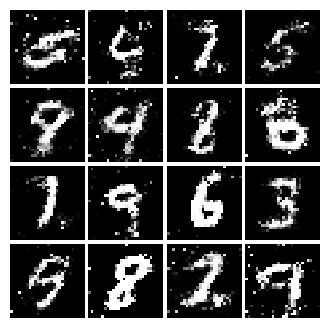


Iter: 4000, D: 0.2278, G:0.1697


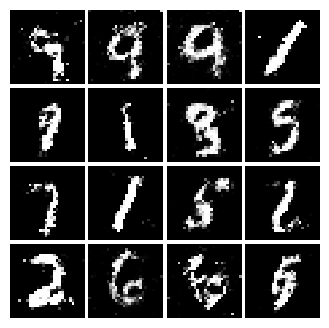


EPOCH:  10
Iter: 4250, D: 0.2198, G:0.1868


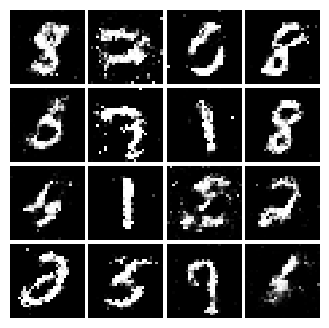


Iter: 4500, D: 0.2297, G:0.1843


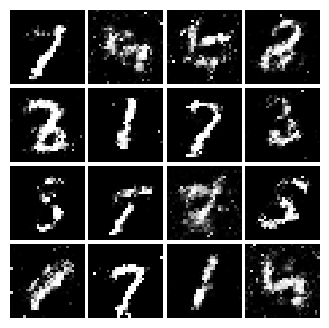

In [10]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device,show_every=250,batch_size=batch_size,noise_size=NOISE_DIM)